In [1]:
import dataset
from visualize import *

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from PIL import Image
from skimage import color
from datasets import load_dataset
from dotenv import load_dotenv
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
from fastprogress.fastprogress import master_bar, progress_bar

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"device: {device}")

device: mps


In [2]:
import lpips
perceptual_loss_fn = lpips.LPIPS(net='alex').to(device)
# d = loss_fn.forward(im0,im1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /Users/matteom/miniconda3/envs/torch/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


### Architecture

In [3]:

class Adain_Encoder(nn.Module):
    def __init__(self, in_channels, out_dim):
        super(Adain_Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, out_dim, kernel_size=3, stride=2, padding=1)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        
        # Global average pooling
        x = self.global_avg_pool(x)        
        # Flatten
        x = x.view(x.size(0), -1)
        
        return x

# Example usage:
# Define input and output dimensions
in_channels = 3  # number of input channels
out_dim = 128  # size of the output representation

# Create an instance of the ConvNet
model = Adain_Encoder(in_channels, out_dim)

# Create a random input tensor
input_tensor = torch.randn(4, in_channels, 256, 256)

# Forward pass
output = model(input_tensor)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 128])


In [4]:
import torch.nn.init as init

class AdaIN(nn.Module):
    
    def __init__(self, style_dim, channels):
        super(AdaIN, self).__init__()
        self.instance_norm = nn.InstanceNorm2d(channels, affine=False)
        self.style_scale_transform = nn.Linear(style_dim, channels)
        self.style_shift_transform = nn.Linear(style_dim, channels)

        ## to ensure they learn different stuff | How tho?
        init.normal_(self.style_scale_transform.weight, mean=1.0, std=0.02)
        init.normal_(self.style_shift_transform.weight, mean=0.0, std=0.02)

        self.style_scale_transform.bias.data.fill_(1)  # Initialize scale to 1
        self.style_shift_transform.bias.data.fill_(0)  # Initialize shift to 0

    def forward(self, x, style):
        '''
        x - feature maps from the unet
        y - learned (jointly) from encoder

        return:
        same size as x
        '''
        # Normalize the input feature map
        normalized = self.instance_norm(x)
        
        # Extract style scale and shift parameters from the style vector
        scale = self.style_scale_transform(style)[:, :, None, None]
        shift = self.style_shift_transform(style)[:, :, None, None]
        
        # Apply scale and shift to the normalized feature map
        transformed = scale * normalized + shift
        
        return transformed

# Example usage:
# Define the dimensions
style_dim = 128  # dimensionality of the style vector
channels = 256    # number of channels in the feature map

# Create an instance of AdaIN
adain = AdaIN(style_dim, channels)

# Generate random input feature map and style vector
x = torch.randn(4, channels, 64, 64)  # Example input feature map
style = torch.randn(1, style_dim)     # Example style vector

# Apply AdaIN

output = adain(x, style)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 256, 64, 64])


In [5]:
mse_loss_fn = nn.MSELoss()
def perceptual_and_MSE_loss(reproduced_image, original_image):
    '''
    reproduced_image: output of the model
    original_image: ground truth
    '''
    # Perceptual loss
    perceptual_loss = perceptual_loss_fn(reproduced_image, original_image).mean()
    
    # MSE loss
    mse_loss = mse_loss_fn(reproduced_image, original_image)
    
    return perceptual_loss + mse_loss

In [6]:
class UNet(nn.Module):
    def __init__(self, in_C = 3, out_C=3, style_dim=128):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)

        '''
        Conv1 shape torch.Size([16, 64, 128, 128])
        Conv2 shape torch.Size([16, 128, 64, 64])
        Conv3 shape torch.Size([16, 256, 32, 32])
        Conv4 shape torch.Size([16, 512, 16, 16])
        Conv5 shape torch.Size([16, 512, 8, 8])
        '''

        self.encoder_adain1 = AdaIN(128, 64)
        self.encoder_adain2 = AdaIN(128, 128)
        self.encoder_adain3 = AdaIN(128, 256)
        self.encoder_adain4 = AdaIN(128, 512)
        self.encoder_adain5 = AdaIN(128, 512)

        self.decoder_adain4 = AdaIN(128, 512)
        self.decoder_adain3 = AdaIN(128, 256)
        self.decoder_adain2 = AdaIN(128, 128)
        self.decoder_adain1 = AdaIN(128, 64)

        if out_C == 3:
            self.style_encoder = Adain_Encoder(in_channels=3, out_dim=128)
        elif out_C == 2:
            self.style_encoder = Adain_Encoder(in_channels=2, out_dim=128)


    def forward(self,x,style_image):
        x=x.to(device)
        style_image = style_image.to(device)

        style = self.style_encoder(style_image).to(device)

        # Encoder
        conv1 = self.conv1(x)
        conv1 = self.encoder_adain1(x,style) ## AdaIN

        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)
        conv2 = self.encoder_adain2(conv2,style) ## AdaIN

        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)
        conv3 = self.encoder_adain3(conv3,style) ## AdaIN

        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)
        conv4 = self.encoder_adain4(conv4,style) ## AdaIN

        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)
        conv5 = self.encoder_adain5(conv5,style) ## AdaIN
        # Decoder
        concatenation_5to6 = torch.cat((conv4,self.decoder_adain4(self.conv_transpose_5to6(conv5),style)),1)
        # concatenation_5to6 = torch.cat((conv4,self.conv_transpose_5to6(conv5)),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        concatenation_6to7 = torch.cat((conv3, self.decoder_adain3(self.conv_transpose_6to7(conv6),style)),1)
        # concatenation_6to7 = torch.cat((conv3, self.conv_transpose_6to7(conv6)),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)

        concatenation_7to8 = torch.cat((conv2, self.decoder_adain2(self.conv_transpose_7to8(conv7),style)),1)
        # concatenation_7to8 = torch.cat((conv2, self.conv_transpose_7to8(conv7)),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        concatenation_8_to9 = torch.cat((conv1, self.decoder_adain1(self.conv_transpose8to9(conv8),style)),1)
        # concatenation_8_to9 = torch.cat((conv1, self.conv_transpose8to9(conv8)),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)

        output = self.conv10(conv9)
        return style, output
    
    def style_loss(self, reproduced_image, encoded_style):
        with torch.no_grad():
            encoded_style_of_reproduced = self.style_encoder(reproduced_image)
        return mse_loss_fn(encoded_style, encoded_style_of_reproduced)
    
    def colorization_plus_style_loss(self, reproduced_image, original_image, encoded_style, alpha=0.5):
        colorization_loss = perceptual_and_MSE_loss(reproduced_image, original_image)
        style_loss = self.style_loss(reproduced_image, encoded_style)
        return alpha * colorization_loss + (1 - alpha) * style_loss, colorization_loss, style_loss

    def train_model(self, train_loader, val_loader, style_train_loader, style_val_loader,
                    epochs=54, 
                    lr=0.0001, 
                    loss_balance=0.5,
                    optimizer=torch.optim.Adam, 
                    verbose=True, 
                    save_path = "./model_storage/", 
                    save_name_prefix='/',
                    colorspace='RGB'):

        loss_df = pd.DataFrame(['training_loss', 'validation_loss'])
        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr)

        #for saving progress
        best_val_loss = 99999
        loss_archive = {"training": {"combined": [],"colorization":[],"style":[]}, "validation": {"combined": [],"colorization":[],"style":[]}}

        mb = master_bar(range(epochs))
        for epoch in mb:
            training_combined_loss = 0
            training_colorizaiton_loss = 0
            training_style_loss = 0
            for i, batch_data in progress_bar(enumerate(train_loader), total=len(train_loader), parent=mb):
                
                # Input grayscale image
                image = batch_data['grayscale_image'].to(device)

                # A batch of style iimages
                for style_batch_data in style_train_loader:
                    batch_of_style_images = style_batch_data['image'].to(device)
                    break

                # Forward pass
                optimizer.zero_grad()
                print(f"images batch size: {image.size()},  style images batch size: {batch_of_style_images.size()}")
                encoded_style, reproduced_image = self(image,batch_of_style_images)
                reproduced_image = reproduced_image.to(device)
                
                if colorspace == 'RGB':
                    combined_loss, colorization_loss, style_loss = self.colorization_plus_style_loss(reproduced_image, batch_data['image'].to(device), encoded_style, alpha=loss_balance)
                elif colorspace == 'LAB':
                    combined_loss, colorization_loss, style_loss = self.colorization_plus_style_loss(reproduced_image, batch_data['image'][:,1:,:,:].to(device), encoded_style, alpha=loss_balance)
                training_combined_loss += combined_loss.item()
                training_colorizaiton_loss += colorization_loss.item()
                training_style_loss += style_loss.item()
                combined_loss.backward()
                optimizer.step()
            
            
            #average training loss and append to achive
            training_combined_loss /= len(train_loader)
            loss_archive["training"]["combined"].append(training_combined_loss)
            training_colorizaiton_loss /= len(train_loader)
            loss_archive["training"]["colorization"].append(training_colorizaiton_loss)
            training_style_loss /= len(train_loader)
            loss_archive["training"]["style"].append(training_style_loss)
            

            if (epoch)%5 == 0 or (epoch + 1) == epochs:
                validation_combined_loss = 0
                validation_colorizaiton_loss = 0
                validation_style_loss = 0
                with torch.no_grad():  # Disable gradient calculation for validation
                    for val_data in val_loader:

                        # Input grayscale image
                        val_image = val_data['grayscale_image'].to(device)
                        # A batch of style images
                        for style_batch_data in style_val_loader:
                            val_batch_of_style_images = style_batch_data['image'].to(device)
                            break
                        
                        # Forward pass
                        encoded_style, val_reproduced_image = self(val_image,val_batch_of_style_images)
                        val_reproduced_image = val_reproduced_image.to(device)
                        if colorspace == 'RGB':
                            combined_loss, colorization_loss, style_loss = self.colorization_plus_style_loss(val_reproduced_image, val_data['image'].to(device),encoded_style,loss_balance)
                        elif colorspace == 'LAB':
                            combined_loss, colorization_loss, style_loss = self.colorization_plus_style_loss(val_reproduced_image, val_data['image'][:,1:,:,:].to(device),encoded_style,loss_balance)
                        validation_combined_loss += combined_loss.item()
                        validation_colorizaiton_loss += colorization_loss.item()
                        validation_style_loss += style_loss.item()
                       
                validation_combined_loss /= len(val_loader)
                loss_archive["validation"]["combined"].append(validation_combined_loss)
                validation_colorizaiton_loss /= len(val_loader)
                loss_archive["validation"]["colorization"].append(validation_colorizaiton_loss)
                validation_style_loss /= len(val_loader)
                loss_archive["validation"]["style"].append(validation_style_loss)
                

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {training_combined_loss}")
                  print(f"Epoch {epoch}: validation loss = {validation_combined_loss}")


                if validation_combined_loss < best_val_loss:  # Update best validation loss and save checkpoint if best model
                  state_diction = self.state_dict()
                  best_val_loss = validation_combined_loss
                  for key in state_diction.keys():
                      state_diction[key] = state_diction[key].to(torch.device('cpu'))
                  torch.save(state_diction, (save_path+save_name_prefix+f"_best_model.pth.tar"))

                #construct df with losses
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  
                                        'training_combined_loss':loss_archive['training']["combined"], 
                                        "training_colorization_loss": loss_archive['training']["colorization"], 
                                        "training_style_loss": loss_archive['training']["style"],
                                        'validation_combined_loss': loss_archive['validation']["combined"],
                                        "validation_colorization_loss": loss_archive['validation']["colorization"],
                                        "validation_style_loss": loss_archive['validation']["style"]})
                loss_df.to_csv(save_path+save_name_prefix+"_loss.csv", index=False)
                # plot losses
                plt.plot(loss_df['epoch'], loss_df['training_combined_loss'], label='Training Loss')
                if loss_balance<0.99:
                    plt.plot(loss_df["epoch"], loss_df["training_colorization_loss"], label="Training Colorization Loss",linestyle='dashed')
                    plt.plot(loss_df["epoch"], loss_df["training_style_loss"], label="Training Style Loss",linestyle='dotted')

                plt.plot(loss_df['epoch'], loss_df['validation_combined_loss'].interpolate(method='linear'), label='Validation Loss')
                if loss_balance<0.99:
                    plt.plot(loss_df["epoch"], loss_df["validation_colorization_loss"].interpolate(method='linear'), label="Validation Colorization Loss",linestyle='dashed')
                    plt.plot(loss_df["epoch"], loss_df["validation_style_loss"].interpolate(method='linear'), label="Validation Style Loss",linestyle='dotted')

                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()

                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'_loss_plot.png')
                plt.clf()
            else:
                loss_archive["validation"]["combined"].append(np.nan)
                loss_archive["validation"]["colorization"].append(np.nan)
                loss_archive["validation"]["style"].append(np.nan)


In [7]:
def load_model_from_checkpoint(checkpoint_path):
    if os.path.exists(checkpoint_path):
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path)
        
        # Create model architecture
        # For example, if your model class is named MyModel:
        model = UNet(in_C=1, out_C=3)
        
        # Load state_dict into the model
        model.load_state_dict(checkpoint)
        
        # Optionally, load other elements from the checkpoint such as optimizer state, etc.
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        print("Model loaded successfully from checkpoint.")
        return model.to(device)
    else:
        print("Checkpoint file does not exist.")
        return None


### Colorization from RGB color space. 

Input is a HxW grayscale image.
Output is a 3xHxW RGB image.

No std and mean normalization is used.

In [8]:
# Kept apart as it must be the SAME for images and styles!
BATCH_SIZE = 10
RESOLUTION = (128,128)
COLORSPACE = 'RGB'

In [9]:
# Actual images:
TRAIN_SIZE = 62
VAL_SIZE = 10

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace=COLORSPACE,resolution=RESOLUTION)
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)

Dataset loaded successfully
Data loader prepared successfully


In [10]:
# Styles:
S_TRAIN_SIZE = 60
S_VAL_SIZE = 10

style_train_data, style_validation_data = dataset.prepare_styles_dataset(train_size=S_TRAIN_SIZE, test_size=S_VAL_SIZE, batch_size=BATCH_SIZE,colorspace=COLORSPACE,resolution=RESOLUTION)
style_train_loader, style_validation_loader = dataset.prepare_styles_dataloader(style_train_data, style_validation_data, batch_size=BATCH_SIZE)

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Dataset loaded successfully
Data loader prepared successfully


In [11]:
TRAIN = False

In [12]:
print("Device is: ", device)
model = UNet(in_C=1, out_C=3).to(device)

if TRAIN:
    model.train_model(train_loader=train_loader, val_loader=validation_loader, 
                        style_train_loader=style_train_loader, style_val_loader=style_validation_loader,
                        epochs=100, lr=0.0001, loss_balance=0.7, optimizer=torch.optim.Adam, verbose=False,
                        save_path= 'combined_losses_experiments/', 
                        save_name_prefix='/UNet-AdaIN_trsize500-100_valsize50-10_combloss07.pth.tar')
    state_diction = model.state_dict()

    for key in state_diction.keys():
        state_diction[key] = state_diction[key].to(torch.device('cpu'))

    torch.save(state_diction, "UNet-AdaIN_trsize500-100_valsize50-10_combined_losses.pth.tar")
else:
    model = load_model_from_checkpoint("/Users/matteom/shared-folder/artistic-colorization-UNet/Unet_adain/combined_losses_experiments/UNet-AdaIN_trsize5000_valsize500_best_model.pth.tar")
    model = model.to(device)

Device is:  mps
Model loaded successfully from checkpoint.


In [ ]:
TRAIN = True

In [ ]:
print("Device is: ", device)
model = UNet(in_C=1, out_C=3).to(device)

if TRAIN:
    model.train_model(train_loader=train_loader, val_loader=validation_loader, 
                        style_train_loader=style_train_loader, style_val_loader=style_validation_loader,
                        epochs=100, lr=0.0001, loss_balance=0.7, optimizer=torch.optim.Adam, verbose=False,
                        save_path= 'combined_losses_experiments/', 
                        save_name_prefix='/UNet-AdaIN_trsize500-100_valsize50-10_combloss07.pth.tar')
    state_diction = model.state_dict()

    for key in state_diction.keys():
        state_diction[key] = state_diction[key].to(torch.device('cpu'))

    torch.save(state_diction, "UNet-AdaIN_trsize500-100_valsize50-10_combined_losses.pth.tar")
else:
    model = load_model_from_checkpoint("/Users/matteom/shared-folder/artistic-colorization-UNet/Unet_adain/combined_losses_experiments/UNet-AdaIN_trsize5000_valsize500_best_model.pth.tar")
    model = model.to(device)

#### Style analysis

In [13]:
validation_data_list = list(validation_data)
validation_style_image_list = list(style_validation_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


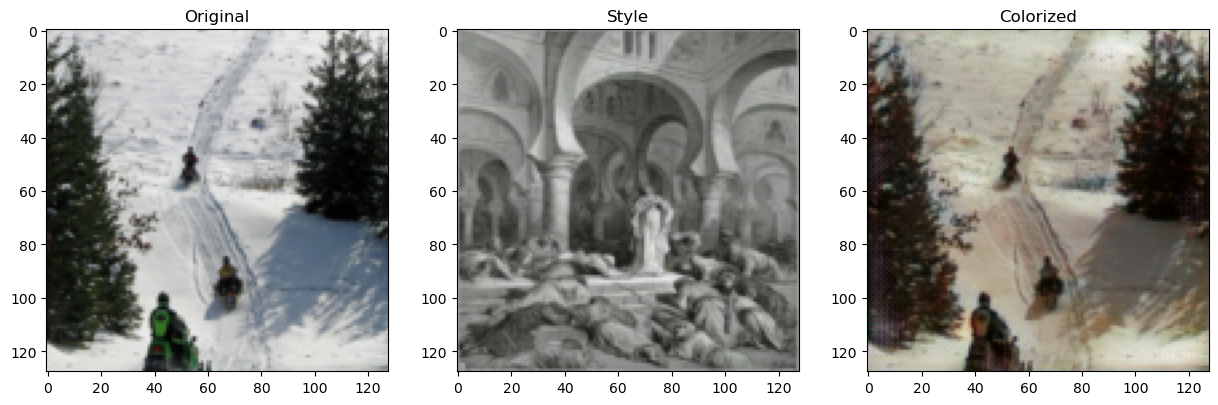

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


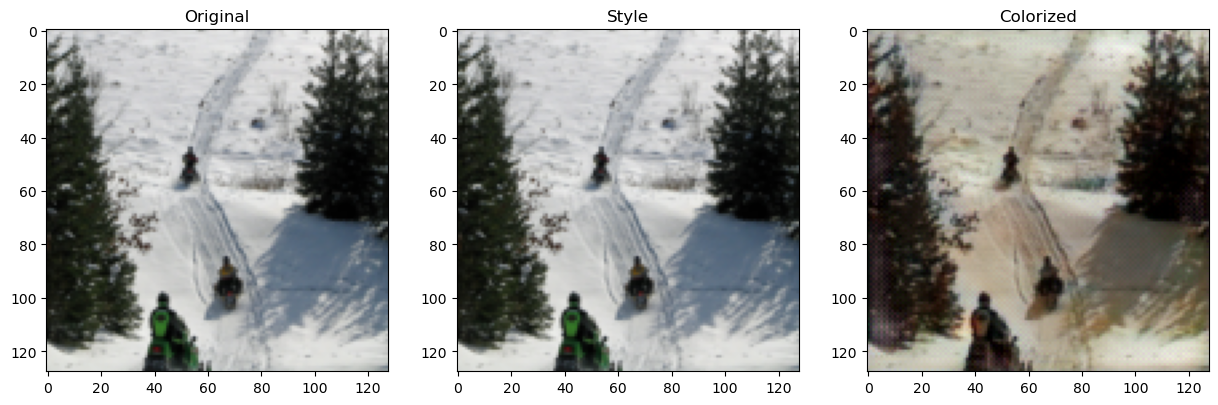

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


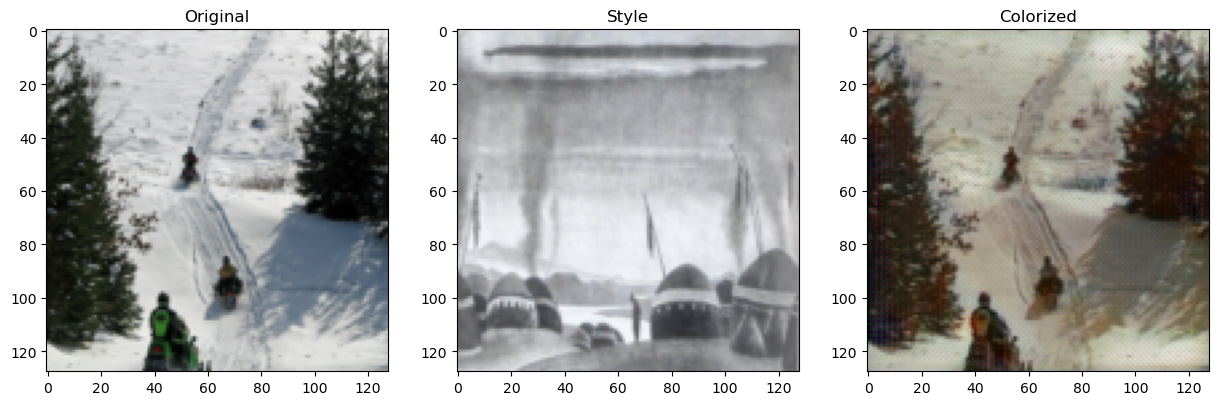

In [14]:
# 1
ground_truth = validation_data_list[2]['image']
input_unet = validation_data_list[2]['grayscale_image']
input_encoder = validation_style_image_list[2]['image']   # To use an actual style image
#input_encoder = validation_data_list[2]['image']        # To use the image itself as style

_, output = model(input_unet.unsqueeze(0).to(device), input_encoder.unsqueeze(0).to(device))
output = output.detach().cpu().squeeze(0)

plot_three(ground_truth.permute(1,2,0).numpy(),input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())

# 2
ground_truth = validation_data_list[2]['image']
input_unet = validation_data_list[2]['grayscale_image']
#input_encoder = validation_style_image_list[2]['image']   # To use an actual style image
input_encoder = validation_data_list[2]['image']        # To use the image itself as style

_, output = model(input_unet.unsqueeze(0).to(device), input_encoder.unsqueeze(0).to(device))
output = output.detach().cpu().squeeze(0)

plot_three(ground_truth.permute(1,2,0).numpy(),input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())

# 3
ground_truth = validation_data_list[2]['image']
input_unet = validation_data_list[2]['grayscale_image']
input_encoder = validation_style_image_list[3]['image']   # To use an actual style image
#input_encoder = validation_data_list[2]['image']        # To use the image itself as style

_, output = model(input_unet.unsqueeze(0).to(device), input_encoder.unsqueeze(0).to(device))
output = output.detach().cpu().squeeze(0)

plot_three(ground_truth.permute(1,2,0).numpy(),input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


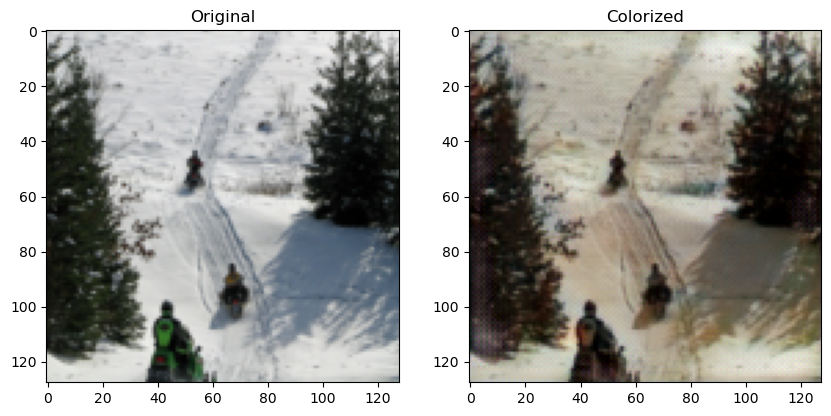

In [15]:
# With colorisation model
ground_truth = validation_data_list[2]['image']
input_unet = validation_data_list[2]['grayscale_image']
#input_encoder = validation_style_image_list[2]['image']   # To use an actual style image
input_encoder = validation_data_list[2]['image']        # To use the image itself as style

_, output = model(input_unet.unsqueeze(0).to(device), input_encoder.unsqueeze(0).to(device))
output = output.detach().cpu().squeeze(0)

plot_both(ground_truth.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())